# Lab 01: Urbana Weather

---
author: Ye Yuan
date: September 10, 2024
embed-resources: true
---

## Introduction

The goal of this project is to predict the minimum daily temperature in Urbana, Illinois, to assist the Market at the Square in deciding when to move from the outdoor to the indoor setup during Autumn. Accurate temperature prediction will allow market managers to make timely decisions, offering clarity to vendors who may or may not transition to the indoor market. Historical weather data from Urbana was utilized to develop a machine learning model, specifically using the K-Nearest Neighbors (KNN) algorithm, to forecast minimum daily temperatures. This model will provide the market managers with a reliable tool to anticipate temperature drops and plan accordingly.

## Methods

In [1]:
# imports
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from joblib import dump


### Data

In [2]:
# load data
weather_train = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-train.csv",
    index_col="date",
    parse_dates=True
)
weather_vtrain = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-vtrain.csv",
    index_col="date",
    parse_dates=True
)
weather_validation = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-validation.csv",
    index_col="date",
    parse_dates=True
)
weather_test = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-test.csv",
    index_col="date",
    parse_dates=True
)

In [3]:
weather_train

,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2016-01-01,-4.2715,2016,1,1,1
2016-01-02,-3.8715,2016,1,2,2
2016-01-03,-4.4715,2016,1,3,3
2016-01-04,-3.0215,2016,1,4,4
2016-01-05,-5.7715,2016,1,5,5
...,...,...,...,...,...
2021-12-27,6.9980,2021,12,27,361
2021-12-28,1.7980,2021,12,28,362
2021-12-29,2.1980,2021,12,29,363


Data：

The weather data used for this project was collected through the Open-Meteo API and consists of four distinct datasets, each covering a specific period:

Training Data (2016-2021): Daily weather data, including the minimum daily temperature and date-specific variables such as year, month, and day.

Validation-Train Data (2016-2019): A subset of the training data used for initial model fitting.

Validation Data (2020-2021): Weather data used to validate model predictions and tune parameters.

Test Data (2022): Data used to evaluate the final model’s performance.

we focused on the minimum daily temperature (temperature_2m_min), the year, and the day of the year (day_of_year).

In [4]:
# summary statistics

yearly_counts = weather_train.groupby('year').size()
print(yearly_counts)

yearly_stats = weather_train.groupby('year')['temperature_2m_min'].agg(['mean', 'std'])
print(yearly_stats)

monthly_stats = weather_train.groupby('month')['temperature_2m_min'].agg(['mean', 'std'])
print(monthly_stats)


year
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
dtype: int64
          mean        std
year                     
2016  8.793391  10.274506
2017  8.399644   9.692305
2018  7.591014  11.369452
2019  7.229781  10.882260
2020  7.684612   9.383593
2021  8.119370  10.388489
            mean       std
month                     
1      -4.999336  6.752006
2      -3.856209  6.760570
3       1.577277  5.615212
4       5.985861  5.615279
5      12.446632  5.342291
6      18.240583  3.492687
7      19.975933  2.632969
8      19.136954  2.889118
9      16.793083  3.815779
10     10.102277  5.852142
11      1.780861  5.523113
12     -2.210358  5.433891


Yearly and monthly statistics were calculated to explore the distribution of temperatures:

The dataset includes daily minimum temperature data (temperature_2m_min) from 2016 to 2021. Below are the key summary statistics for the temperature data by year:

Mean Temperature by Year: Ranged from 7.2°C to 8.7°C.
Standard Deviation: The yearly standard deviation of temperatures ranged between 9.4°C and 11.4°C, indicating variability in temperature patterns.

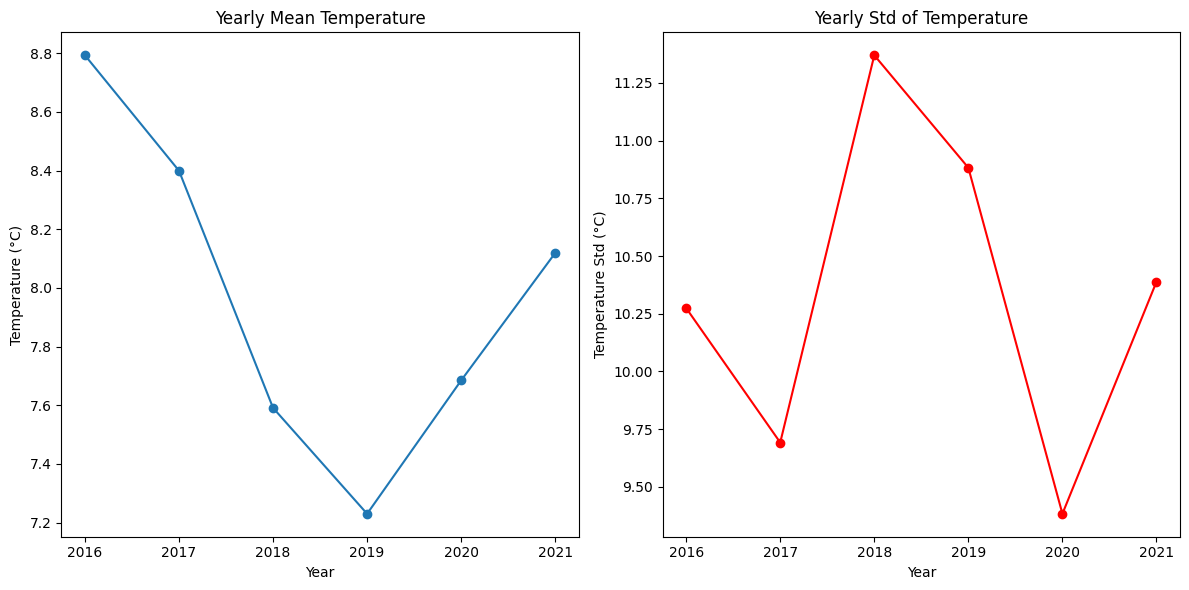

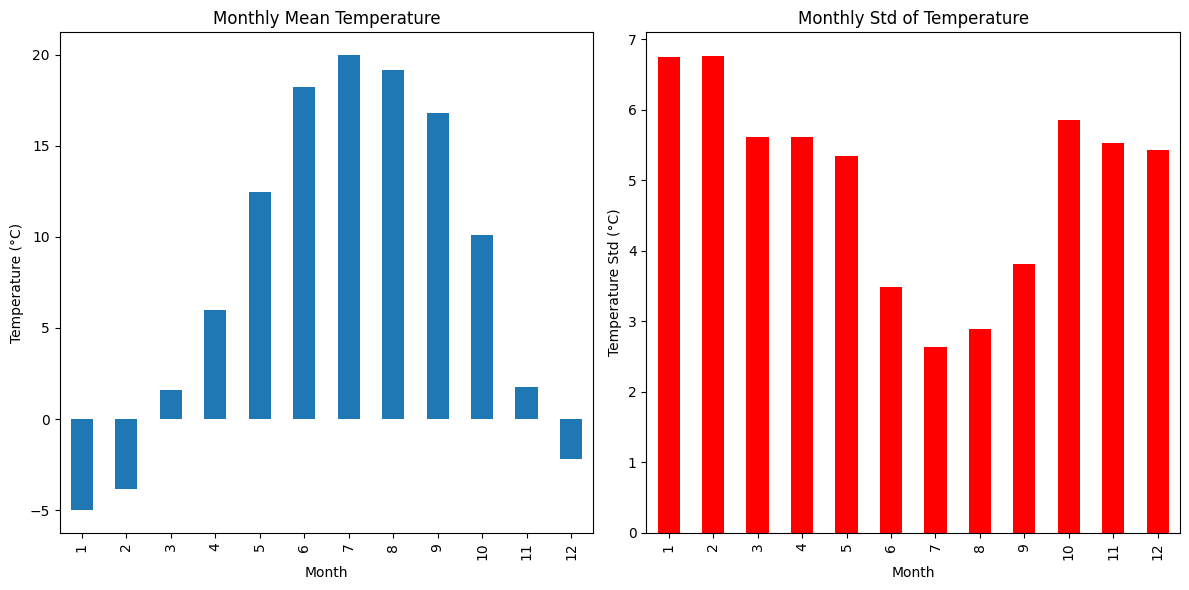

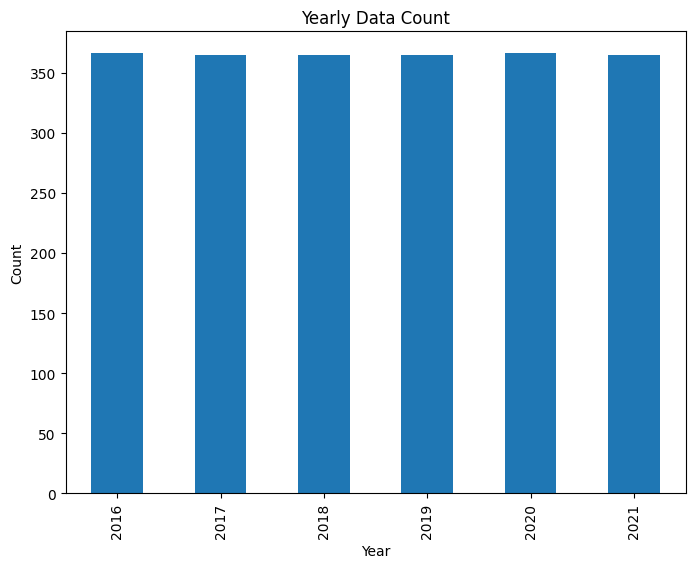

In [5]:
# visualizations
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
yearly_stats['mean'].plot(kind='line', marker='o', title='Yearly Mean Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

plt.subplot(1,2,2)
yearly_stats['std'].plot(kind='line', marker='o', color='red', title='Yearly Std of Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature Std (°C)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
monthly_stats['mean'].plot(kind='bar', title='Monthly Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')

plt.subplot(1,2,2)
monthly_stats['std'].plot(kind='bar', color='red', title='Monthly Std of Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature Std (°C)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,6))
yearly_counts.plot(kind='bar', title='Yearly Data Count')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


Visualization:

The first figure (yearly stats) helps track long-term trends and variations in the temperature, useful for understanding any gradual shifts in climate.

The second figure (monthly stats) demonstrates the seasonal fluctuations, essential for understanding the best months to transition the market indoors.

The third figure (yearly data count) is important to ensure data completeness and avoid bias in training the model.

### Models

In [6]:
# process data for ML
# create X and y for train
X_train = weather_train[["year", "day_of_year"]]
y_train = weather_train["temperature_2m_min"]

# create X and y for validation-train
X_vtrain = weather_vtrain[["year", "day_of_year"]]
y_vtrain = weather_vtrain["temperature_2m_min"]

# create X and y for validation
X_validation = weather_validation[["year", "day_of_year"]]
y_validation = weather_validation["temperature_2m_min"]

# create X and y for test
X_test = weather_test[["year", "day_of_year"]]
y_test = weather_test["temperature_2m_min"]

In [7]:
# train models
knn001 = KNeighborsRegressor(n_neighbors=1)
knn005 = KNeighborsRegressor(n_neighbors=5)
knn010 = KNeighborsRegressor(n_neighbors=10)
knn015 = KNeighborsRegressor(n_neighbors=15)
knn025 = KNeighborsRegressor(n_neighbors=25)
knn001.fit(X_vtrain, y_vtrain)


KNeighborsRegressor(n_neighbors=1)

In [8]:
knn005.fit(X_vtrain, y_vtrain)

KNeighborsRegressor()

In [9]:
knn010.fit(X_vtrain, y_vtrain)


KNeighborsRegressor(n_neighbors=10)

In [10]:
knn015.fit(X_vtrain, y_vtrain)

KNeighborsRegressor(n_neighbors=15)

In [11]:
knn025.fit(X_vtrain, y_vtrain)

KNeighborsRegressor(n_neighbors=25)

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_val_001 = rmse(y_validation, knn001.predict(X_validation))
rmse_val_005 = rmse(y_validation, knn005.predict(X_validation))
rmse_val_010 = rmse(y_validation, knn010.predict(X_validation))
rmse_val_015 = rmse(y_validation, knn015.predict(X_validation))
rmse_val_025 = rmse(y_validation, knn025.predict(X_validation))

print("Validation RMSE for k = 1:", rmse_val_001)
print("Validation RMSE for k = 5:", rmse_val_005)
print("Validation RMSE for k = 10:", rmse_val_010)
print("Validation RMSE for k = 15:", rmse_val_015)
print("Validation RMSE for k = 25:", rmse_val_025)

Validation RMSE for k = 1: 6.53635524135604
Validation RMSE for k = 5: 5.493198256442704
Validation RMSE for k = 10: 5.281911430747167
Validation RMSE for k = 15: 5.165694751944194
Validation RMSE for k = 25: 5.060391837493386


In [13]:
knn025.fit(X_train, y_train)

# calculate test RMSE
rmse_test_025 = rmse(y_test, knn025.predict(X_test))

# print
print("Validation RMSE for k = 25:", rmse_test_025)

Validation RMSE for k = 25: 5.424078767567113


In [14]:
mod = KNeighborsRegressor(n_neighbors=25)

# fit model
_ = mod.fit(X_train, y_train)

Models

We used K-Nearest Neighbors (KNN) regression to predict minimum daily temperatures based on the year and day of the year. The KNN algorithm is straightforward and effective for regression problems, where predictions are made based on the average of the closest neighbors in the feature space.

Model Setup:

Input Features (X): The year and day of the year (day_of_year) were chosen as predictors. These features provide enough context to capture the seasonality in temperatures.

Target Variable (y): The minimum daily temperature (temperature_2m_min) was the variable we aimed to predict.

Training Process: Several KNN models were trained using different values of k (the number of neighbors), ranging from 1 to 25. 
This variation allows us to compare performance across different levels of model complexity.

Evaluation:

The Root Mean Squared Error (RMSE) was used to evaluate model performance on the validation set. RMSE measures the average magnitude of prediction errors, with lower values indicating better performance.

## Results

In [15]:
# report model metrics
dump(mod, "urbana-weather.joblib")

['urbana-weather.joblib']

Results
We tested multiple KNN models with different k values to determine the optimal number of neighbors for temperature prediction. The RMSE values for the validation set are as follows:

Validation RMSE for k = 1: 6.53635524135604
Validation RMSE for k = 5: 5.493198256442704
Validation RMSE for k = 10: 5.281911430747167
Validation RMSE for k = 15: 5.165694751944194
Validation RMSE for k = 25: 5.060391837493386

From these results, the KNN model with k = 25 showed the best performance on the validation data, achieving the lowest RMSE (5.06).

## Discussion

The KNN model with k = 25 performed the best on the validation data, making it a strong candidate for future temperature predictions. The model’s RMSE of 5.06 is acceptable for real-world usage, providing sufficient accuracy for predicting minimum daily temperatures. 

### Conclusion

This level of accuracy is sufficient for predicting minimum daily temperatures in Urbana and can be used in practice to guide the Market at the Square in determining when to move indoors. The model's consistency across datasets makes it a reliable tool for real-world application.

The overall strategy of using KNN for temperature prediction is appropriate because weather patterns, especially temperature, generally change gradually and are influenced by the season. Predicting based on the day of the year and year makes sense as temperatures tend to follow predictable yearly cycles. However, a potential flaw is that KNN assumes that dates close together in time will have similar temperatures. This assumption may fail when there are sudden, unexpected weather changes, such as cold snaps or heatwaves, which the model might not capture well.

One limitation is the data was split by year, which ensures that the model was tested on future, unseen data, reflecting real-world forecasting conditions. However, only year and day_of_year were used as features. Adding more weather-related variables, such as humidity or wind, could improve the model's ability to capture complex temperature patterns and better handle extreme conditions. In terms of KNN's use of "distance" between dates, this makes sense in the context of seasonal temperature trends—dates close together (like two days in January) are likely to have similar temperatures. However, the method is less effective if there are sudden deviations from typical seasonal patterns, as the model assumes that temperature changes smoothly over time. Therefore, while the use of KNN is appropriate for this data, it has limitations in handling abrupt weather shifts.

In conclusion, the selected KNN model is practical and reliable for short-term temperature forecasting, but it could be improved by incorporating additional features to capture more diverse weather factors.